# Evaluation on Synthetic Data

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import root_mean_squared_error, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [3]:
from famo.synthetic import DataGenerator
from famo.utils_gpu import get_free_gpu_idx
from famo.plotting import lined_heatmap

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7f759b57c410>


In [5]:
# plotting settings
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")

Run a quick check if GPU(s) are available and select the least utilized GPU to perform the optimization.

In [6]:
device = "cpu"
try:
    device = f"cuda:{get_free_gpu_idx()}"
except Exception as e:
    print(e)

First, lets generate some multi-view synthetic data. The dataset comprises 200 samples and four views, each having 400 features. In addition, the underlying relationships across views consist of 2 factors shared among all views, 14 factors shared among a subset of two or three views, as well as a private factor for each view. Finally, we may introduce additional covariates that can be modelled jointly during training.

In [7]:
seed = 0
n_samples = 200
n_features = [400, 400, 400, 400]
n_views = len(n_features)
likelihoods = ["normal" for _ in range(n_views)]
n_covariates = 0

In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed, all_combs=True)
dg.normalise()

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.
Generating all possible binary combinations of 4 variables.
New factor configuration: 1 fully shared, 10 partially shared, 4 private factors.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

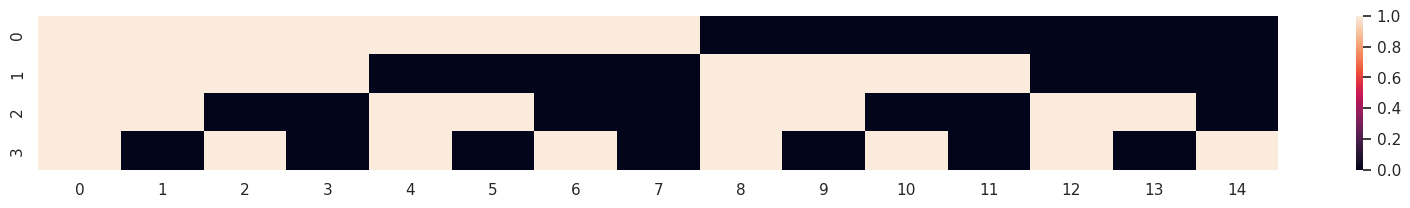

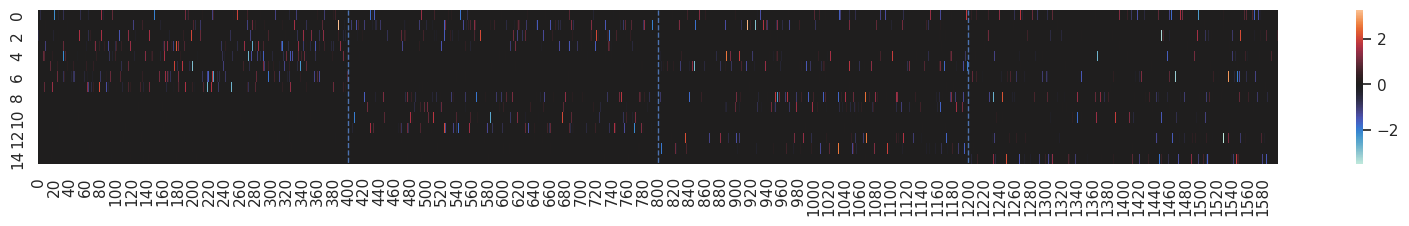

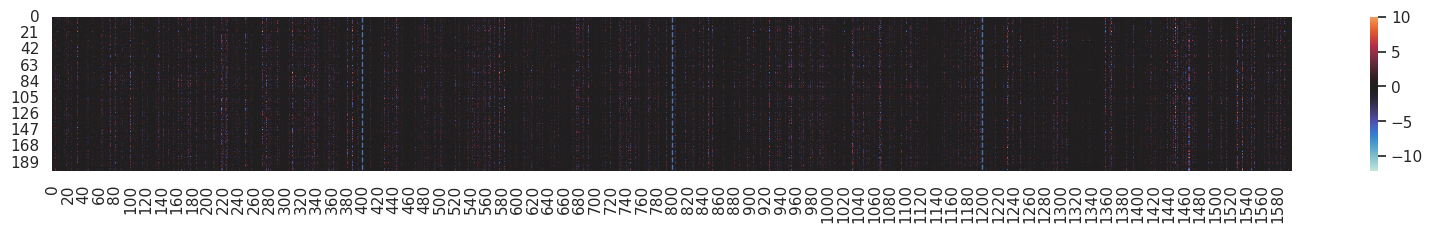

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.view_factor_mask)
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

Now we can perturb the true underlying mask of the factor loadings in order to inform the model noisy feature sets. We do so by introducing false positives and false negatives controlled by a `noise_fraction` parameter. We may also determine which views we would like to inform via `informed_views`, a list of view indices. Here we only inform the first view (index 0).

Factor 8 is completely off, inserting 9.97%% false positives.
Factor 9 is completely off, inserting 9.97%% false positives.
Factor 10 is completely off, inserting 9.97%% false positives.
Factor 11 is completely off, inserting 9.97%% false positives.
Factor 12 is completely off, inserting 9.97%% false positives.
Factor 13 is completely off, inserting 9.97%% false positives.
Factor 14 is completely off, inserting 9.97%% false positives.


<Axes: >

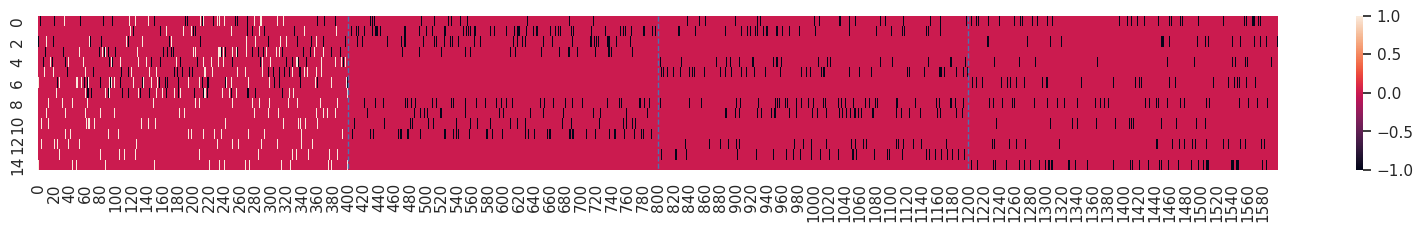

In [11]:
# perturb
noise_fraction = 0.5
# inform only first view with noisy prior
informed_views = [0]

_ = dg.get_noisy_mask(
    rng,
    noise_fraction=noise_fraction,
    informed_view_indices=informed_views,
)

# false positives and false negatives
lined_heatmap(dg.noisy_w_mask.astype(int) - dg.w_mask.astype(int), vlines=vlines)

Now that we generated a noisy version of the true factor loadings mask, we need to inform our model by relaxing the binary prior information to values larger than zero for the slab widths of the regularized horseshoe. We do so by providing a `prior_confidence` that ranges from 0 to 1 when adding the prior mask. The `prior_confidence` encodes our prior belief regarding the (noisy) prior information. A weak belief corresponds to values around 0.97, medium to 0.99 and strong to 0.995 or larger (closer to 1.0). As a rule of thumb, a `prior_confidence` of around 0.99 provides the best results on average. In this notebook we use a low `prior_confidence` of 0.97, as we have distorted the prior information quite severely, and we are informing only one out of four views.

In [12]:
mdata = dg.to_mdata(noisy=True)
mdata

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 200 × 1600
  uns:	'likelihoods', 'n_active_factors'
  obsm:	'z'
  4 modalities
    feature_group_0:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_3:	200 x 400
      varm:	'w', 'w_mask'

In [13]:
def pearson_corr(x, y, signed=False):
    pstat = pearsonr(x, y).statistic
    if not signed:
        pstat = abs(pstat)
    return pstat

In [14]:
from scipy.optimize import linprog


def optim_perm(matrix):
    n, n = matrix.shape
    res = linprog(
        -matrix.ravel(),
        A_eq=np.r_[
            np.kron(np.identity(n), np.ones((1, n))),
            np.kron(np.ones((1, n)), np.identity(n)),
        ],
        b_eq=np.ones((2 * n,)),
        bounds=n * n * [(0, None)],
    )
    assert res.success
    shuffle = res.x.reshape(n, n).T
    shuffle[np.abs(shuffle) < 1e-2] = 0.0
    return shuffle

/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-08-16 14:22:32,517 - muvi.core.models - WARNING - No view names provided!
2024-08-16 14:22:32,518 - muvi.core.models - INFO - Setting the view names to the sorted list of dictonary keys in observations.
2024-08-16 14:22:32,523 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,524 - muvi.core.models - INFO - Storing the index of the view `feature_group_0` as sample names.
2024-08-16 14:22:32,525 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,526 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,527 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,528 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,529 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,530 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,532 - muvi.core.models - INFO - pd.DataFrame detected.
2024-08-16 14:22:32,537 - muvi.core.models - INFO - np.ndarray detected.
20

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

2024-08-16 14:22:34,907 - root - INFO - Guessed max_plate_nesting = 3


 15%|████▏                       | 1485/10000 [02:03<11:49, 12.00it/s, ELBO=851]

Relative improvement of -0.0001148 < 1e-05 for 10 step(s) in a row, stopping early.
2024-08-16 14:24:36,467 - muvi.core.models - INFO - Call `model._training_log` to inspect the training progress.


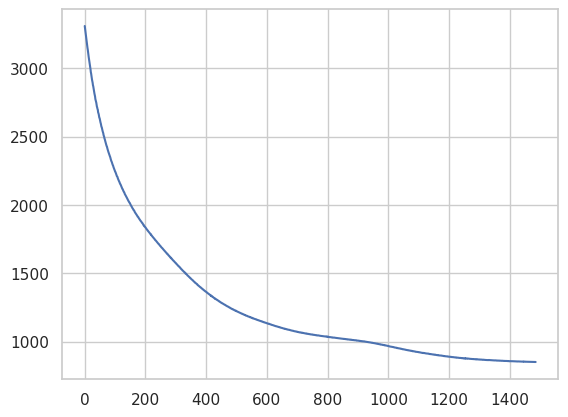

2024-08-16 14:24:36,649 - muvi.tools.utils - WARNING - Cache has not yet been setup, initialising model cache.


/home/aqoku/miniconda3/envs/famo/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


{'feature_group_0': 0.3166353,
 'feature_group_1': 0.44851077,
 'feature_group_2': 0.34782815,
 'feature_group_3': 0.35133004}

In [15]:
import muvi
model_muvi = muvi.tl.from_mdata(
    mdata, prior_mask_key="w_mask", prior_confidence=0.97, device=device
)
model_muvi
model_muvi.fit(seed=0)
plt.plot(model_muvi._training_log["history"])
plt.show()
muvi.tl.rmse(model_muvi)[0]

In [16]:
from famo.core import CORE

In [17]:
# Run model with MuData object
model_famo = CORE(device=device)

Setting up device...
- Running all computations on `cuda:2`


In [18]:
model_famo.fit(
    data=mdata,
    n_factors=1,
    annotations={vn: mdata[vn].varm["w_mask"].T for vn in mdata.mod},
    weight_prior="Horseshoe",
    factor_prior="Normal",
    likelihoods={vn: "Normal" for vn in mdata.mod},
    covariates_key=None,
    nonnegative_weights=False,
    nonnegative_factors=False,
    prior_penalty=0.03,
    batch_size=0,
    max_epochs=10000,
    n_particles=5,
    lr=0.005,
    early_stopper_patience=500,
    print_every=500,
    plot_data_overview=False,
    scale_per_group=False,
    use_obs=None,
    use_var=None,
    save=False,
    save_path=None,
    init_factors="random",
    init_scale=0.1,
    seed=0,
)

Fitting model...
- Checking compatibility of provided likelihoods with data.
  - feature_group_0: Normal
  - feature_group_1: Normal
  - feature_group_2: Normal
  - feature_group_3: Normal
- Centering group_1/feature_group_0...
- Centering group_1/feature_group_1...
- Centering group_1/feature_group_2...
- Centering group_1/feature_group_3...
Initializing factors using `random` method...
{'feature_group_0': 1.0, 'feature_group_1': 1.0, 'feature_group_2': 1.0, 'feature_group_3': 1.0}
Decaying learning rate over 10000 iterations.
Setting training seed to `0`.
Cleaning parameter store.
2024-08-16 14:24:38,184 - root - INFO - Guessed max_plate_nesting = 4
Epoch:       0 | Time:       0.44s | Loss:   12916.34
Epoch:     500 | Time:      49.42s | Loss:    3874.89
Epoch:    1000 | Time:      99.80s | Loss:    3343.64
Epoch:    1500 | Time:     149.58s | Loss:    3296.33
Epoch:    2000 | Time:     199.46s | Loss:    3279.36
Epoch:    2500 | Time:     251.67s | Loss:    3270.32
Epoch:    3000 |

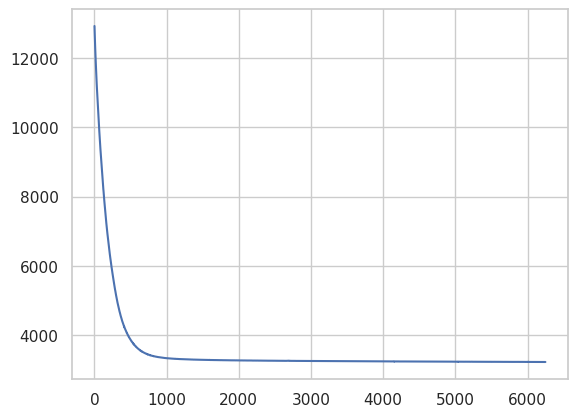

In [19]:
plt.plot(model_famo.train_loss_elbo)

In [20]:
model_famo._factor_order = np.arange(model_famo.n_factors)
model_famo.factor_order

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [21]:
assert (np.array(model_famo.sample_names["group_1"], dtype=np.int32) == np.arange(dg.n_samples)).all()

In [34]:
model = model_muvi
# model = model_famo
model

|=======================================================================================================================|
|                                                  MuVI version 0.1.4                                                   |
|=======================================================================================================================|
| Parameter        | Value                                                                                              |
|------------------|----------------------------------------------------------------------------------------------------|
| n_views          | 4                                                                                                  |
| n_samples        | 200                                                                                                |
| n_features       | feature_group_0: 400, feature_group_1: 400, feature_group_2: 400, feature_group_3: 400             |
| n_factors        | 15 

In [35]:
if type(model).__name__ == "MuVI":
    ws_hat = [model.get_factor_loadings()[vn] for vn in model.view_names]
    z_hat = model.get_factor_scores()
else:
    ws_hat = [model.get_weights("numpy")[vn] for vn in model.view_names]
    z_hat = model.get_factors("numpy")["group_1"]

In [36]:
w_hat = np.concatenate(ws_hat, axis=1)
ys_hat = [z_hat @ w for w in ws_hat]
y_hat = np.concatenate(ys_hat, axis=1)

w_hat = w_hat[model.n_dense_factors:, :]
z_hat = z_hat[:, model.n_dense_factors:]

In [37]:
# overall RMSE
root_mean_squared_error(dg.y, y_hat)

0.36607605987745345

Once the training converges, we may inspect the learned parameters and compare them to the true parameters.

<Axes: >

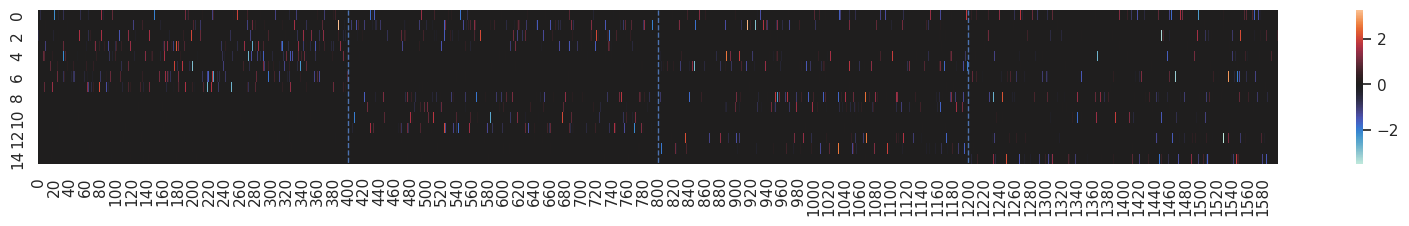

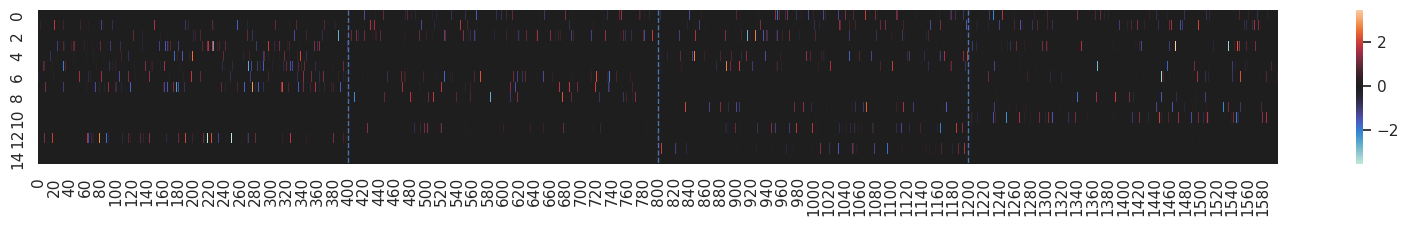

In [38]:
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)

Due to non-identifiability of FA models, it is sometimes necessary to permute the order of the factors match the true order. We do so by first computing the cosine similarities between the true factor loadings mask and the learned factor loading activations (based on a threshold). Then, we find the optimal permutation by matching each factor with its corresponding true factor index based on the largest cosine similarity.

<Axes: >

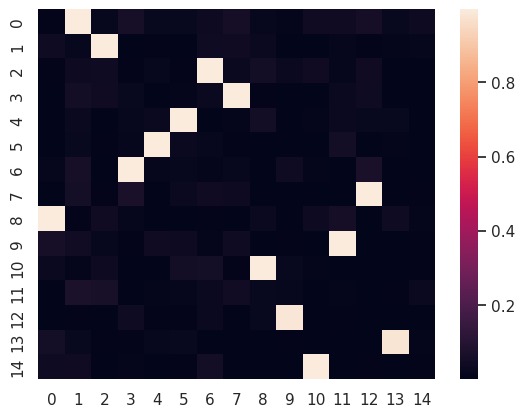

In [39]:
corr_mat = pairwise_distances(dg.w, w_hat, metric=pearson_corr)
sns.heatmap(corr_mat)

<Axes: >

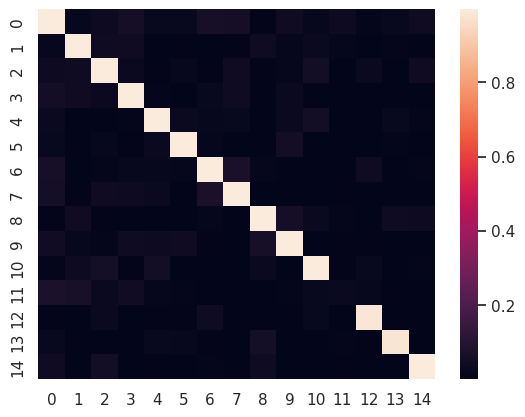

In [40]:
opt_order = optim_perm(corr_mat).argmax(axis=0)
sns.heatmap(corr_mat[:, opt_order], annot=False)

Our model also infers the relationship across subsets of views by learning a set of `factor_scales` for each view. The lower the value of a factor scale $k$ in view $m$, the less significant this factor is for view $m$.

In [41]:
if type(model).__name__ == "MuVI":
    factor_scales = model._guide.get_factor_scale()[:, model.n_dense_factors:]
else:
    factor_scales = (
        torch.cat(
            [
                model.variational.expectation(f"inter_scale_w_feature_group_{m}")[model.n_dense_factors:, :, :][opt_order, :]
                for m in range(4)
            ],
            axis=1,
        )
        .squeeze()
        .detach()
        .cpu()
        .numpy()
        .T
    )
factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
factor_scales = factor_scales

<Axes: >

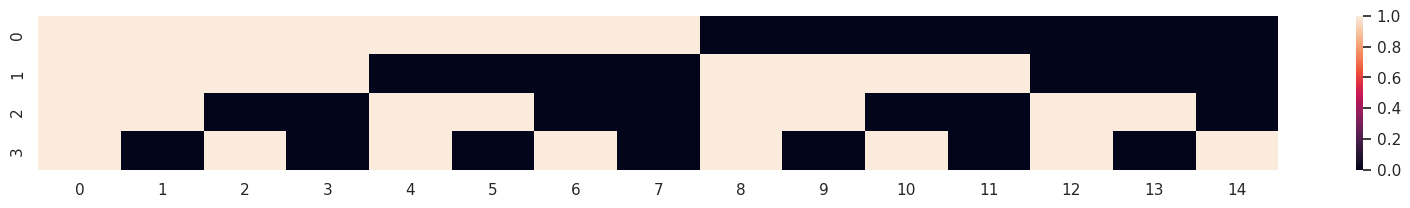

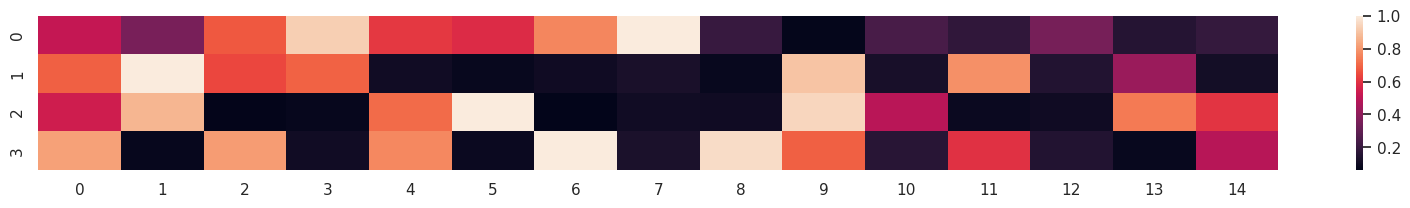

In [42]:
lined_heatmap(dg.view_factor_mask)
lined_heatmap(factor_scales)

We can also go one level deeper and inspect a single factors by extractin its factor loadings and plotting the sorted weights along with their corresponding state, one of true positive (TP), true negative (TN), false positive (FP) and false negative (FN). Ideally we would like to see true active loadings away from zero, i.e. true positives (TP), false negatives (FN), and true inactive loadings close to zero, i.e. false positives (FP), true negatives (TN)

In [43]:
from famo.plotting import factor_activity

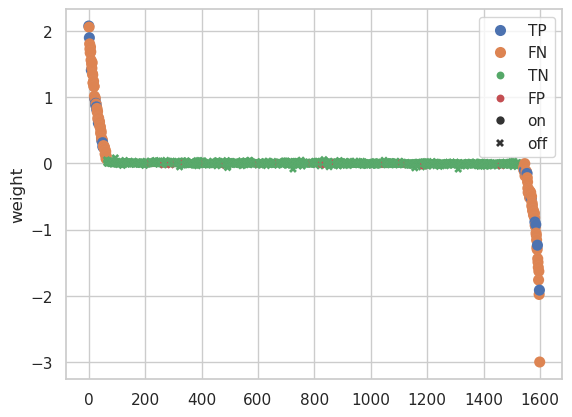

In [44]:
g, _ = factor_activity(
    dg.w, w_hat[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=0
)

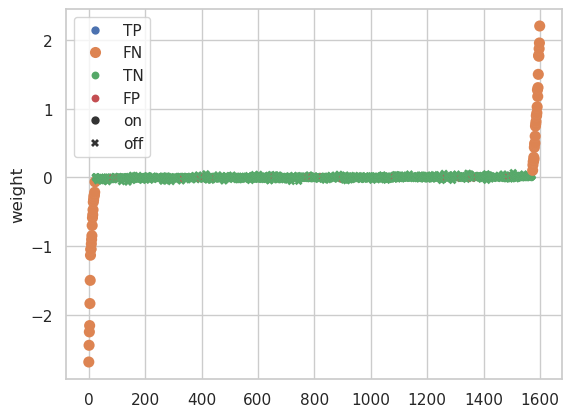

In [45]:
g, _ = factor_activity(
    dg.w, w_hat[opt_order, :], dg.w_mask, dg.noisy_w_mask, factor_idx=10
)